In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader,random_split
from torchvision import transforms, datasets, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
model = models.resnet18(weights=None)
model.fc=nn.Linear(model.fc.in_features,120)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/Images'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=20,eta_min=1e-9)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    scheduler.step()

    
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

    

100%|██████████| 33/33 [00:09<00:00,  3.58it/s]

Epoch 29/100: training accuracy: 0.9588057445200302, valid accuracy: 0.5879494655004859,train loss: 0.14318455489739115,valid loss:1.7060408855202827


In [7]:
torch.save(model.state_dict(),'RestNet18_dog_model.pt')

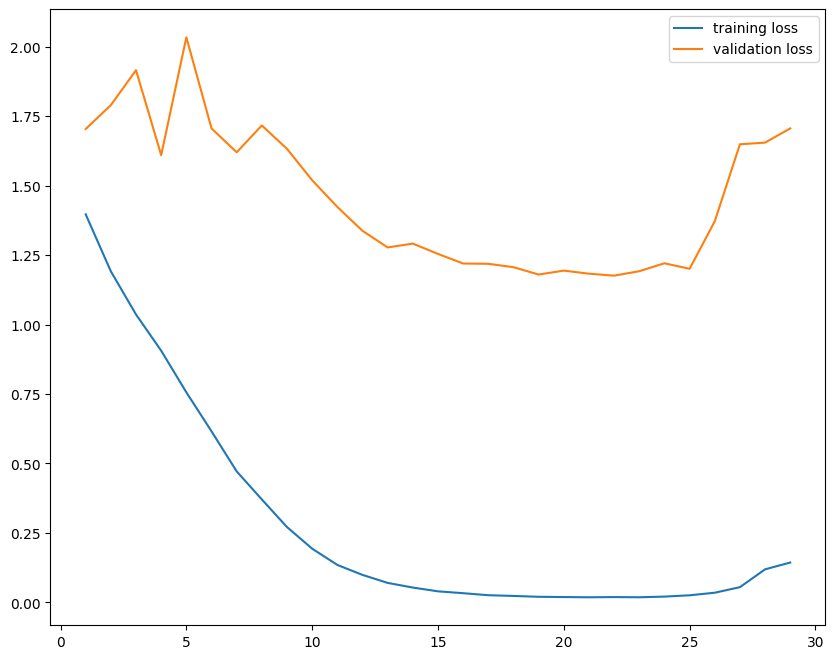

In [8]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()        
